# Backdoor Criterion

A main interest is in causal analysis is to estimate the effect of one variable $X$ (cause) on another $Y$ (effect); in general, $X$ and $Y$ could be mutually exclusive sets of variables. Motivating examples are the following.

- What's the effect of smoking on lung cancer?
- What's the effect of studying on grades?
- What's the effect of carbon emission on climate change?

The problem with estimating "causal" effect is with confounders. Confounders are variables that influence both the cause and effect. Confounders lead to spurios associations and add noise to the estimation of causal effects. If we can identify confounders, then we can control, block or freeze their influence and isolate and estimate the causal effects of $X$ on $Y$. 

In a directed acyclic graph (DAG) partially representing a causal model, we can use the `Backdoor criterion` to identify confounders. A set of variables $Z$ satisifies the backdoor criterion relative to $X$ and $Y$ if the following are true:

- $Z$ blocks all backdoor paths from $X$ to $Y$
- $Z$ does not contain any descendants of $X$

Backdoor paths have arrows leading into $X$ (meaning, backdoor paths start from $X$ and then to its parents and ultimately $Y$). Backdoor paths are commonly referred to as non-causal pathways. Frontdoor paths have arrows leading away from $X$ (meaning, frontdoor paths start from $X$ and then to its children and ultimately $Y$). Frontdoor paths are commonly referred to as causal pathways. For the two conditions above, correspondingly,

- we find all active backdoor paths and identify confounders (the magic is to find variables of active backdoor paths that are not in a collider configuration), and
- we leave all frontdoor paths alone (e.g. avoid post-treatment biase)

Finding confounders is much easier than the ideas above. According to the [confounder selection criterion](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6447501/), given the DAG, simply use the parents of $X$, $Y$ or both as confounders. This approach is easy, but a bit too crude and brute force; it might be that during real-world validation, some parents of $X$ or $Y$ are not practical/ethical to control for, and we need to find other confounders. 

Once we have identify counfounders, then we can use the `backdoor adjustment formula` to estimate the causal effect.

$P(y|do(x)) = \sum_z P(y|x,z) P(z)$

Let's have fun and see how we can programmatically find confounders using the backdoor criterion. We will take some networks from the following videos (which explains the backdoor criterion very well).

- `g1`: [4.6 - The Backdoor Adjustment](https://www.youtube.com/watch?v=U1S8Rq8IcrY)
- `g2`: [07-5 d-Separation and Backdoor Criterion](https://www.youtube.com/watch?v=yoPk3PL9-KY)

## Build graphs

Let's build the graphs.

In [15]:
import networkx as nx
from collections import namedtuple

Graph = namedtuple('Graph', 'u, d')

def get_edges(s):
    edges = s.split('\n')
    edges = map(lambda line: line.split('->'), edges)
    edges = map(lambda tokens: tuple([t.strip() for t in tokens]), edges)
    edges = list(edges)

    return edges

def get_directed_graph(edges):
    g = nx.DiGraph()
    g.add_edges_from(edges)

    return g

def get_undirected_graph(edges):
    g = nx.Graph()
    g.add_edges_from(edges)

    return g

def get_graph(s):
    e = get_edges(s)

    d = get_directed_graph(e)
    u = get_undirected_graph(e)
    g = Graph(u, d)

    return g

In [16]:
s = '''
W2 -> W1
W2 -> W3
W1 -> T
C -> T
T -> M
W3 -> Y
C -> Y
M -> Y
'''.strip()

g1 = get_graph(s)

In [17]:
s = '''
W -> Z
U -> Z
U -> T
Z -> X
X -> T
X -> Y
T -> Y
'''.strip()

g2 = get_graph(s)

Now let's visualize the graphs.

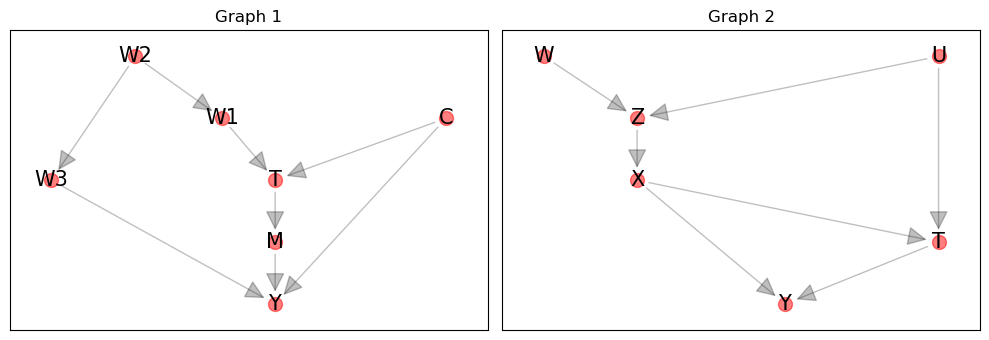

In [18]:
import matplotlib.pyplot as plt

def plot_graph(g, ax):
    pos = nx.nx_agraph.graphviz_layout(g.d, prog='dot')
    
    nx.draw_networkx_nodes(
        G=g.d,
        pos=pos,
        ax=ax,
        node_size=100,
        alpha=0.5,
        node_color='red'
    )
    
    nx.draw_networkx_labels(
        G=g.d,
        pos=pos,
        ax=ax,
        font_size=15,
        font_color='black',
        alpha=1.0
    )
    
    nx.draw_networkx_edges(
        G=g.d,
        pos=pos,
        alpha=0.25,
        arrowsize=30,
        ax=ax
    )

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

plot_graph(g1, ax[0])
plot_graph(g2, ax[1])

ax[0].set_title('Graph 1')
ax[1].set_title('Graph 2')

fig.tight_layout()

## Confounder identification

The algorithm to find confounders is as follows.

- Input
  - $G$: DAG
  - $X$: cause
  - $Y$: effect
- Output: $Z$ confounders
- Find all the paths $P$ between $X$ and $Y$
- For all active backdoor path $p$ in $P$, find the colliders $C$
- Find all the descendants of $X$, $D$
- Denote $A$ as all the nodes in the active backdoor paths, then $Z = A \setminus C \cup D \cup X \cup Y$
- return $Z$

In [37]:
import itertools

def get_all_paths(g, start, stop):
    return nx.all_simple_paths(g.u, start, stop)

def get_path_triplets(path):
    if len(path) < 3:
        return [path]
    else:
        return [path[i:i+3] for i in range(0, len(path) - 2)]

def get_triplet_type(g, x, z, y):
    x_children = set(g.d.successors(x))
    z_children = set(g.d.successors(z))
    y_children = set(g.d.successors(y))

    if z in x_children and y in z_children:
        return 'serial'
    if z in y_children and x in z_children:
        return 'serial'
    if x in z_children and y in z_children:
        return 'diverging'
    if z in x_children and z in y_children:
        return 'converging'
    raise Exception(f'cannot determine triplet configuration: x={x}, z={z}, y={y}')

def is_active_triplet(g, x, z, y, evidence=set()):
    triplet_type = get_triplet_type(g, x, z, y)

    if triplet_type in {'serial', 'diverging'}:
        if z in evidence:
            return False
        else:
            return True
    else:
        z_set = nx.descendants(g.d, z)
        z_set.add(z)

        if len(z_set & evidence) > 0:
            return True
        else:
            return False

def is_active_path(g, path, evidence=set()):
    if len(path) < 3:
        if path[0] in evidence or path[-1] in evidence:
            return False
        else:
            return True

    path_triplets = get_path_triplets(path)

    for x, z, y in path_triplets:
        if not is_active_triplet(g, x, z, y, evidence):
            return False
    return True

def get_colliders(g, path):
    if len(path) < 3:
        return []

    path_triplets = get_path_triplets(path)
    return [z for x, z, y in path_triplets if get_triplet_type(g, x, z, y) == 'converging']
    
def get_paths(g, x, y):
    def is_backdoor_path(p):
        if g.d.has_edge(p[1], p[0]):
            return True
        return False

    def is_frontdoor_path(p):
        if g.d.has_edge(p[0], p[1]):
            return True
        return False
        
    def get_path_metadata(p):
        return {
            'path': p,
            'is_active': is_active_path(g, p),
            'colliders': get_colliders(g, p),
            'backdoor': is_backdoor_path(p),
            'frontdoor': is_frontdoor_path(p)
        }
    paths = get_all_paths(g, x, y)
    return [get_path_metadata(p) for p in paths]

def get_backdoors(g, x, y):
    paths = get_paths(g, x, y)

    colliders = [p['colliders'] for p in paths if p['is_active'] == False and p['backdoor'] == True]
    colliders = itertools.chain(*colliders)
    colliders = set(colliders)
    # print(f'{colliders=}')
    
    descendants = nx.descendants(g.d, x)
    # print(f'{descendants=}')

    exclude = colliders | descendants | {x, y}
    # print(f'{exclude=}')

    candidates = [[n for n in p['path'] if n not in exclude] for p in paths if p['is_active'] == True and p['backdoor'] == True]
    # print(f'{candidates=}')
    candidates = itertools.chain(*candidates)
    candidates = set(candidates)

    return candidates

The first graph actually has backdoor paths. Thus, the candidate confounders are $C, W_1, W_2, W_3$. Note that the weakness of this algorithm, as it is, is that it does not identify the minimal set of confounders to condition on. We only need to include $W_1$, $W_2$ or $W_3$ and not all of them.

In [38]:
get_paths(g1, 'T', 'Y')

[{'path': ['T', 'W1', 'W2', 'W3', 'Y'],
  'is_active': True,
  'colliders': [],
  'backdoor': True,
  'frontdoor': False},
 {'path': ['T', 'C', 'Y'],
  'is_active': True,
  'colliders': [],
  'backdoor': True,
  'frontdoor': False},
 {'path': ['T', 'M', 'Y'],
  'is_active': True,
  'colliders': [],
  'backdoor': False,
  'frontdoor': True}]

In [39]:
get_backdoors(g1, 'T', 'Y')

{'C', 'W1', 'W2', 'W3'}

The second graph has no backdoor paths. Thus, there are no confounders identified!

In [40]:
get_paths(g2, 'W', 'Y')

[{'path': ['W', 'Z', 'U', 'T', 'X', 'Y'],
  'is_active': False,
  'colliders': ['Z', 'T'],
  'backdoor': False,
  'frontdoor': True},
 {'path': ['W', 'Z', 'U', 'T', 'Y'],
  'is_active': False,
  'colliders': ['Z'],
  'backdoor': False,
  'frontdoor': True},
 {'path': ['W', 'Z', 'X', 'T', 'Y'],
  'is_active': True,
  'colliders': [],
  'backdoor': False,
  'frontdoor': True},
 {'path': ['W', 'Z', 'X', 'Y'],
  'is_active': True,
  'colliders': [],
  'backdoor': False,
  'frontdoor': True}]

In [32]:
get_backdoors(g2, 'W', 'Y')

set()